In [1]:
"""
Created on Wed March 2 13:44:00 2022

@author: seanmb

This file will show you some of the basic uses of KINECAL
It uses the sway_utils library to calculate the metrics.
"""

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import os
import sys

sys.path.append(os.path.abspath(".."))
from sway_utils.recordings import KinectRecording
import sway_utils.metrics as sm

start_frame = 200
end_frame = 500

"""" 
25 and 201 are included in the sample data.  
once you downlad the coplete KINECAL dataset you can extend these arrays to compaire more partipants.
"""
HAs = [25]   #[25, 504, 505] #Healthy Adults
CaRs = [201] #[201, 309, 311] #Clinically at Risk

In [2]:
# """
# view depth files

# The depth files are stored as ushort values in binary format.

# Below, is a code sippit to allow you to open individual files.

# """

# file_path = os.path.abspath('./25/25_Quiet-Standing-Eyes-Open/depth/DepthUshort63690582245431.bin')
# depth_image = np.fromfile(file_path, dtype='ushort')
# depth_image = depth_image.reshape([424, 512])


# """
# It is can be useful to use different colour maps to view the depth informaiton
# """
# plt.imshow(depth_image, cmap='binary')
# plt.show()
# plt.imshow(depth_image, cmap='jet')
# plt.show()
# plt.imshow(depth_image, cmap='prism')
# plt.show()
# plt.imshow(depth_image, cmap='bone')
# plt.show()

In [3]:
# """
# Save in depth files as images

# If you are saving the depth images scaling the images to 0-255 and converting to unit8 is a advisable

# Note it this is a destrucive process and you should work with the raw depth data in your models
# """

# import imageio
# depth_image_for_saving = (depth_image-np.min(depth_image))/(np.max(depth_image)-np.min(depth_image))*255
# depth_image_for_saving = depth_image_for_saving.astype('uint8')
# imageio.imwrite('saved_depth_image.jpeg', depth_image_for_saving)


# def centre(data):
#     """
#     This method is uesed to centre the CoM pathes by subtrcting the 
#     mean value from each value in the CoM path
#     """
#     data_mean = np.mean(data)
#     centred_data = np.subtract(data, data_mean)
#     return centred_data

In [4]:

def centre(data):
    """
    This method is uesed to centre the CoM pathes by subtrcting the 
    mean value from each value in the CoM path
    """
    data_mean = np.mean(data)
    centred_data = np.subtract(data, data_mean)
    return centred_data


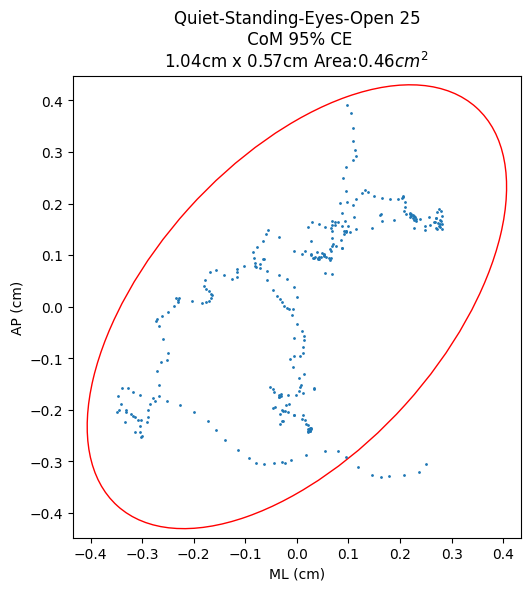

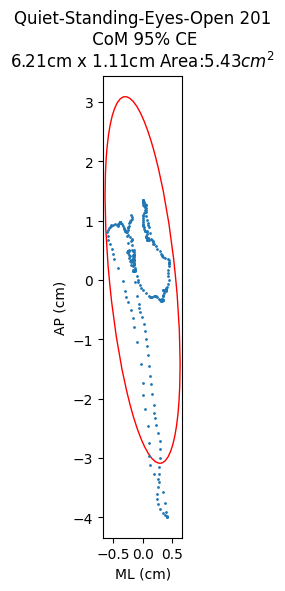

In [5]:
"""
This section uses the sway_utils library to produce a stabilogram for each of the participant records.
Three healthy adults and three Clinically-at-risk participants are used to provide a comparison.

The records are processed using the recording object from the sway_utils library.

NOTE: The first time the files are processed, cache files for joint positions 
will be created (.csv and .npy).  Subsequent runs will use the cache, making analysis much quicker.
In addition, the csv file is a convenient format for 3rd party analysis.

The data are filtered using a butterworth filter and is saved into a [3, 26, 599] (axis, joint, frame) array called stacked_filtered_XYZ_values
The raw values are also cached and stored in an array called stacked_raw_XYZ_values.

CoM positions are estimated using the Euclidean mean of the HIP_LEFT HIP_RIGHT SPINE_MID.
the mean position of HIP_LEFTx HIP_RIGHTx SPINE_MIDx represents the ML-axis
the mean position of HIP_LEFTz HIP_RIGHTz, SPINE_MIDz represents the AP-axis

The CoM values can be converted to stabilograms, using the confidence_ellips method of the sway_utils library,
and displayed using Matplotlib

NOTE: the data are centred, and a standardised x and y scale is used to make the comparison easier.

Quiet standing, eyes open, is used in this comparison.

"""

"""
Default start and end have been frames are set to 200-500, these have been used to create the sway metrics.csv files,
you can create custom ranges to suite your needs.
Note this will affect the area calculation.
"""
#start_frame = 100
#end_frame = start_frame + (30*10)

#start_frame = 0
#end_frame = start_frame + (30*20)


for part_id in HAs+CaRs:
    str_part_id = str(part_id)
        
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    """
    It is often useful to set the plot area to aid comparison. If you would like to do this uncomment the code below.
    """
    #ax.set_xlim([-5, 5])
    #ax.set_ylim([-5, 5])
    
    skel_root_path = os.path.abspath('data/sample_set/' + str_part_id + '/' + str_part_id + '_Quiet-Standing-Eyes-Open/skel')
    recording = KinectRecording(skel_root_path, "", 'Quiet-Standing-Eyes-Open', str_part_id)
   
    ML_path = centre(recording.stacked_filtered_XYZ_values[0, 25][start_frame:end_frame]*100) # the midle 10 seconds are retreived and converted to cm
    AP_path = centre(recording.stacked_filtered_XYZ_values[2, 25][start_frame:end_frame]*100)
        
    elp, width, height, AREA_CE, angle = sm.confidence_ellipse(ML_path, 
                                                                AP_path, 
                                                                ax, 
                                                                n_std=1.96,
                                                                edgecolor='red')
    AREA_CE = round(AREA_CE, 2)
    
    ax.scatter(ML_path, AP_path, s=1)
   
    ax.set_title('Quiet-Standing-Eyes-Open ' + str_part_id + '\n CoM 95% CE' + 
                  '\n' + str(round(width, 2)) + 'cm' + 
                  ' x ' + 
                  str(round(height, 2)) + 'cm' + 
                  ' Area:' + str(AREA_CE) + '$cm^2$')
    
    ax.set_aspect('equal')
    plt.xlabel('ML (cm)')
    plt.ylabel('AP (cm)')
    plt.show()

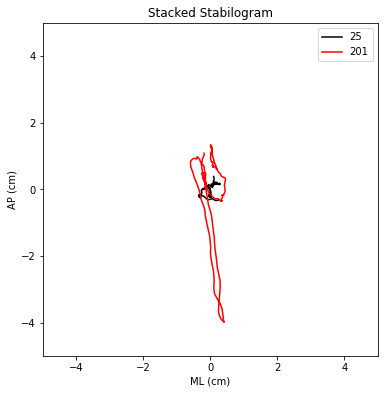

In [6]:
"""
Sometimes it is better to plot two or more stabilograms on the same graph.

Read in Skeleton files using the recording object.

Note if this is the first time you are reading the files cache files for joint positions 
will be created (.csv and .npy).  Subsiquent runns with use the cashe.

These values are filterd using a butterworth filter and is saved into a [3, 26, 599] (axis, joint, frame) array called stacked_filtered_XYZ_values

The CoM value is used here to create a stabilogram.  
Note the value are centred to make comparison eaiser.

"""
plt.figure(figsize=(6, 6), dpi=72)
plt.xlim([-5, 5])
plt.ylim([-5, 5])

line_style = ['-', '--', '-.', ':']


line_index = 0
for part_id in HAs:
    str_part_id = str(part_id)
    skel_root_path = os.path.abspath('data/sample_set/' + str_part_id + '/' + str_part_id + '_Quiet-Standing-Eyes-Open/skel')
    recording = KinectRecording(skel_root_path, "", 'Quiet-Standing-Eyes-Open', str_part_id)
    plt.plot(centre(recording.stacked_filtered_XYZ_values[0, 25][start_frame:end_frame])*100,
            centre(recording.stacked_filtered_XYZ_values[2, 25][start_frame:end_frame])*100, 
            color='black', linestyle=line_style[line_index])
    line_index += 1

line_index = 0
for part_id in CaRs:
    str_part_id = str(part_id)
    skel_root_path = os.path.abspath('data/sample_set/' + str_part_id + '/' + str_part_id + '_Quiet-Standing-Eyes-Open/skel')
    recording = KinectRecording(skel_root_path, "", 'Quiet-Standing-Eyes-Open', part_id)
    plt.plot(centre(recording.stacked_filtered_XYZ_values[0, 25][start_frame:end_frame])*100,
            centre(recording.stacked_filtered_XYZ_values[2, 25][start_frame:end_frame])*100, 
            color='red', linestyle=line_style[line_index])
    line_index += 1

plt.legend(HAs + CaRs, loc=1)
plt.title('Stacked Stabilogram')
plt.xlabel('ML (cm)')
plt.ylabel('AP (cm)')
plt.show()

  0%|          | 0/417 [00:00<?, ?it/s]/home/timo/mdf/sway_utils/recordings.py:1018: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spine_base = np.stack([skel_frame['X'][SkeletonJoints.SPINEMID.value], skel_frame['Y'][SkeletonJoints.SPINEMID.value], skel_frame['Z'][SkeletonJoints.SPINEMID.value]])
/home/timo/mdf/sway_utils/recordings.py:1019: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hip_left = np.stack([skel_frame['X'][SkeletonJoints.HIPLEFT.value], skel_frame['Y'][SkeletonJoints.HIPLEFT.value], skel_frame['Z'][SkeletonJoints.HIPLEFT.value]])
/home/timo/mdf/sway_utils/recordings.py:1020: FutureWarning: Series.__

AttributeError: 'DataFrame' object has no attribute 'append'

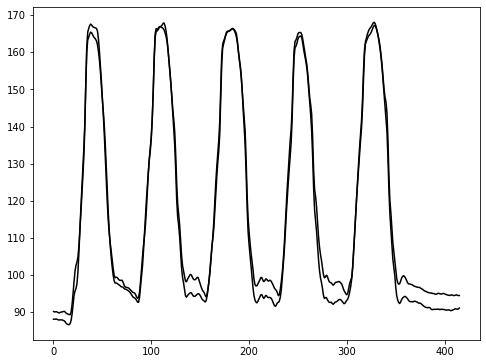

In [ ]:
BASE = "/home/timo/mdf/data/sample_set"

plt.figure(figsize=(8, 6), dpi=72)

# Healthy adult
skel_root_path = os.path.join(BASE, str(HAs[0]), f"{HAs[0]}_STS-5", "skel")
recording = KinectRecording(skel_root_path, "", 'STS-5', HAs[0])
recording.calculate_walked_skel_angles()
KNEE_left = recording.walked_skel_angles['KNEELEFT_a_SP']
KNEE_right = recording.walked_skel_angles['KNEERIGHT_a_SP']
plt.plot(KNEE_left, color='black')
plt.plot(KNEE_right, color='black')

# Clinically at risk
skel_root_path = os.path.join(BASE, str(CaRs[0]), f"{CaRs[0]}_STS-5", "skel")
recording = KinectRecording(skel_root_path, "", 'STS-5', CaRs[0])
recording.calculate_walked_skel_angles()
KNEE_left = recording.walked_skel_angles['KNEELEFT_a_SP']
KNEE_right = recording.walked_skel_angles['KNEERIGHT_a_SP']
plt.plot(KNEE_left, color='red')
plt.plot(KNEE_right, color='red')

plt.legend([
    f"{HAs[0]}_KNEE_left", f"{HAs[0]}_KNEE_right",
    f"{CaRs[0]}_KNEE_left", f"{CaRs[0]}_KNEE_right"
], loc=1)

plt.xlabel('frame #')
plt.ylabel('relative angle (deg)')
plt.show()
